In [155]:
import sys
import numpy as np
import matplotlib
import librosa
from matplotlib import pyplot as plt
import librosa.display

#from scipy.io import wavfile
from scipy import signal
from scipy.fft import fftshift
from IPython.display import Audio
import soundfile

def getFIRFFT(H,order, flag_window=1, flag_display=0):
    
    NFFT=len(H)*2-1
    # real 부분을 뒤집어서 pi~ 2pi부분에 넣는다.
    mirrored=np.concatenate([H,np.flip(np.conjugate(H[0:-1]),axis=0)],axis=0)
    mirrored=mirrored+(0j)
    
    # 중앙을 기준으로 좌우 대칭인 것을 ifft한다.
    iffted=np.fft.ifft(mirrored, axis=0)
    iffted=np.concatenate([iffted[len(H):], iffted[0:len(H)]])

    if flag_display==1: # 디버깅용 플롯
        plt.figure()
        plt.plot(np.arange(len(mirrored))*np.pi*2/len(mirrored),mirrored)
        plt.title("Mirrored time-domain signal")

        plt.figure()
        plt.plot(np.arange(len(iffted)),np.real(iffted))
        plt.title("iffted signal")
        
    # 원하는 order에 해당하는 만큼만 잘라낸다.
    h=iffted[len(H)-order//2:len(H)+order//2 ]
    h=h.real
    
    if flag_window ==1: # 필요하다면 hamming window를 적용한다.
        window=signal.windows.hamming(len(h))
        h=h*window    
    return h

def Visualize_plots(h,H_wanted): # 플롯 띄우는 함수
    # h : 시간차원에서의 신호
    # H_wanted : 원하는 주파수 응답
    
    H_result=np.abs(np.fft.fft(h,1024))
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.plot(np.arange(len(h)),h)
    plt.title("time-domain filter result")
    plt.subplot(1,2,2)
    plt.plot(np.arange(len(H_result)//2)*np.pi/(len(H_result)//2),H_result[:len(H_result)//2])
    plt.plot(np.arange(len(H_wanted))*np.pi/len(H_wanted),H_wanted)
    plt.title("Freq response of filter")
    plt.legend(["result","wanted"])
    plt.show()
    
def Spectrogram(x,Ns,Nf,flag_hamm):
    # x : 음성신호
    # Ns: shift number of samples
    # Nf: frame number of samples
    # flag_hmm: switch for hamming window 1/0 (ON/OFF)
    T = len(x)   # number of samples
    #num_frames = T//Nf# 마지막 채워지지 않은 프레임은 버린다. 구현에 따라 zero-padding해서 사용 가능
    num_frames = (T-Nf)//Ns + 1 
    hNo = Nf//2+1

    X = np.zeros((hNo,num_frames),dtype="complex")
    
    if flag_hamm >0: # window setting
        win = librosa.filters.get_window('hamming', Nf, fftbins=True)
    else:
        win = np.ones(Nf)
        
    for i in range(num_frames):
        y = x[(i*Ns):(i*Ns+Nf)]

        y=np.fft.fft(y*win) 
        X[:,i]= y[:hNo]

    return X

def filtering(h, x, prevx,out_len):# 필터링 후 원하는 길이만큼 출력해주는 함수
    # h : 시간차원 필터
    # x : 시간차원 신호
    # prevx : 버퍼 초기화
    # out_len : 원하는 출력 길이
    Lx=len(x)
    x_i=np.concatenate([prevx,x])
    y=np.convolve(x_i,h,"same")
    
    prevx=x_i[-len(prevx):]
    
    return y[-out_len:], prevx

def get_Wiener_filter(x,Ns,Nf,order,E_n): # wiener filter를 구해주는 함수
    # x : 시간차원 신호
    # Ns: shift할 길이
    # Nf: 프레임의 크기
    # order: wiener filter의 크기
    # E_n : 추정된 noise의 주파수 특성
    X=np.squeeze(Spectrogram(x,Ns,Nf,1))
    E_x=np.real(np.conj(X)*X)
    H=(E_x-E_n)/E_x
    H[H < 1/32]=1/32 # clipping
    h=getFIRFFT(H,order,) # time-domain filter
    
    return h

x_, Fs=librosa.load("./kdigits1-3.wav") # 시간차원에서의 음성 신호
n, Fs=librosa.load("./lab04_car.wav")   # 노이즈 신호

L_min=min(len(x_),len(n))

E_x=np.mean(x_[:L_min]**2)
E_n=np.mean(n[:L_min]**2)
SNR=10**(15/20)

x= E_x/E_n*SNR*n[:L_min]+x_[:L_min] # SNR을 고려한 mixing

Ts=0.01 # 10ms
Tf=0.01 # 10ms
Tover=0.003
Ns=int(Fs*Ts)
Nf=int(Fs*Tf)



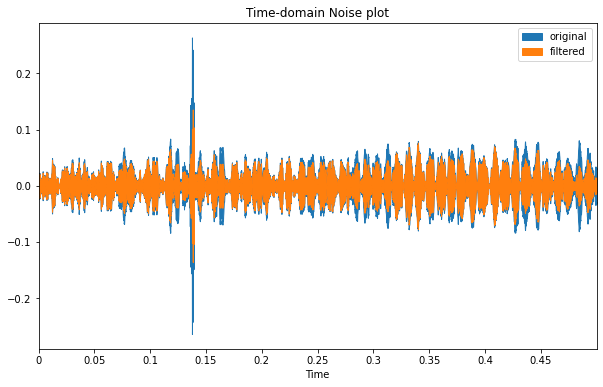

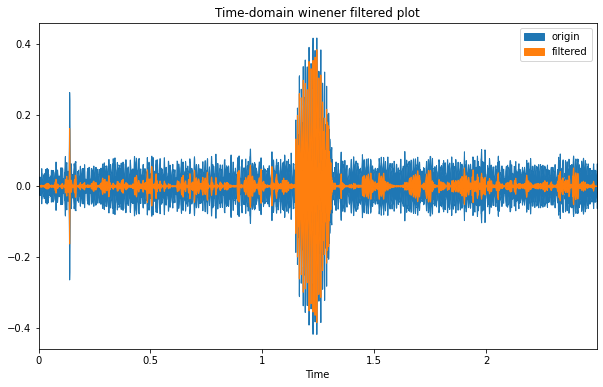

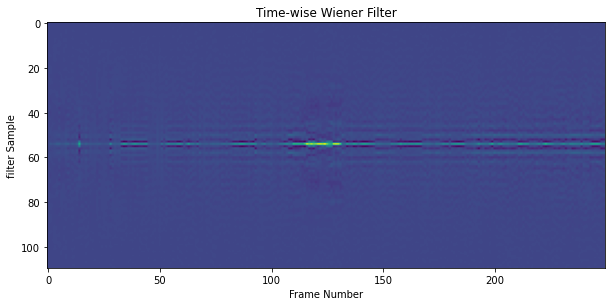

In [164]:
#######################################################

# 입력신호의 0~0.5 [sec]에 노이즈만 있다고 가정한 경우

    # Wiener filter가 잘 동작해서, 잡음의 에너지가 더 작아졌음을 
    # 1,2번째 figure를 통해 알 수 있다.
    
    # 시간에 대한 Wiener filter의 변화 (3번째 figure)를 보면
    # 음성신호가 있는 부분에서 유난히 impulse와 가까운 것을 확인할 수 있는데,
    # 이는, 노이즈 신호와 음성신호의 통계적 특성이 많이 다르기 때문이다.
    # 해당 구간에서 음성신호를 거의 그대로 출력해주고,
    # 그 외의 구간에서는 음성신호의 특성과 달라서 억재해줬음을 알 수 있다.

#######################################################

Nover=int(Fs*Tover) # overlap될 길이 (trapezoidal의 사용을 위해 정의됨)

N_noise=int(0.5*Fs)#0.5[sec]
N=Spectrogram(x[:N_noise],Ns,Nf,1)
E_n=np.mean(np.real(N*np.conj(N)),axis=-1) # 노이즈 신호의 주파수 특성의 추정치

order=len(E_n)
N_frame=int(len(x)/Nf)
upslope=np.linspace(0,1,Nover+2)[1:-1]

mem_x=np.zeros(order-1+Nover) # on-line필터링을 위한 버퍼

y=np.zeros(int(N_frame*Nf))
Wiener_Stack=np.zeros((order-1,N_frame))

for f_idx in range(1,N_frame): # on-line을 가정한 wiener필터링
    x_i=x[(f_idx-1)*Ns:(f_idx-1)*Ns+Nf]
    h=get_Wiener_filter(x_i,Ns,Nf,order,E_n)
    Wiener_Stack[:,f_idx]=h 
    y_tmp,mem_x = filtering(h,
                            x_i,
                            mem_x,
                            Nover+Nf
                           )#  Wiener filter의 적용
    
    if (f_idx-1)*Nf-Nover>=0: # trapezoidal window의 적용
        y[(f_idx-1)*Nf-Nover:(f_idx-1)*Nf]=y[(f_idx-1)*Nf-Nover:(f_idx-1)*Nf]+upslope*y_tmp[:Nover]
        y[(f_idx-1)*Nf:(f_idx)*Nf]=y_tmp[Nover:]
        y[(f_idx)*Nf-Nover:(f_idx)*Nf]=y[(f_idx)*Nf-Nover:(f_idx)*Nf]*np.flip(upslope)
    else:
        y[(f_idx-1)*Nf:(f_idx)*Nf]=y_tmp[Nover:]
        y[(f_idx)*Nf-Nover:(f_idx)*Nf]=y[(f_idx)*Nf-Nover:(f_idx)*Nf]*np.flip(upslope)        

#############################        

# 시간차원에서의 결과 출력 

#############################
plt.figure(figsize=[10,6])
librosa.display.waveplot(x[:N_noise],Fs) # 추정한 노이즈 구간
librosa.display.waveplot(x[:N_noise]-y[:N_noise],Fs) # 필터링 후 추정된 노이즈 
plt.title("Time-domain Noise plot")
plt.legend(["original","filtered"])


plt.figure(figsize=[10,6])
librosa.display.waveplot(x,Fs) # 입력으로 들어온 신호
librosa.display.waveplot(y,Fs) # Wiener filtering이 적용된 결과
plt.title("Time-domain winener filtered plot")
plt.legend(["origin","filtered"])


plt.figure(figsize=[10,10])
plt.imshow(Wiener_Stack) # Wiener filter의 시간에 따른 변화를 출력
plt.title("Time-wise Wiener Filter")
plt.xlabel("Frame Number")
plt.ylabel("filter Sample")

Audio(y,rate=Fs)
soundfile.write("./kdigits1-3_WienerFiltred.wav",y,Fs)

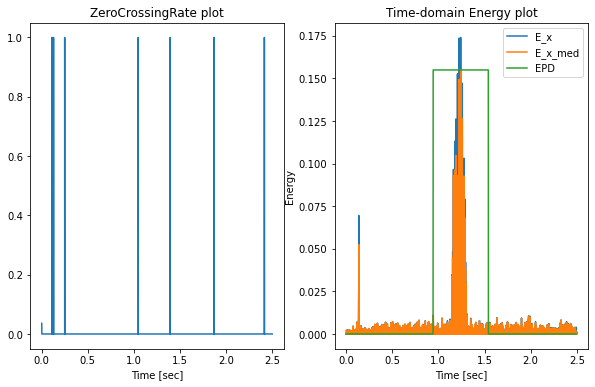

In [165]:

def median_filtering(x,L_filter,prevx): # median을 계산하는 필터
    # x : 시간차원의 신호
    # L_filter : median필터의 길이
    # prevx : 필터링 버퍼
    
    x_i= np.concatenate([prevx,x])
    N_frame=int(len(x_i)/L_filter)
    y=np.zeros(len(x))
    for idx in range(len(x)-L_filter):
        y[idx]=np.median(x_i[(idx):idx+L_filter])

    prevx=x_i[-len(prevx):]
    
    return y,prevx

Envelop_x=x**2 # 에너지 계산


m_order=5 # 에너지 계산을 위한 median filter의 길이
prevx=np.ones(m_order-1)*np.mean(Envelop_x)

N_frame=int(len(Envelop_x)/Nf)

Envelop_med=np.zeros(len(Envelop_x))

m_order_2=7 # ZCR계산을 위한 median filter의 길이
pseudo_zcr=np.zeros(len(Envelop_x))
prev_zcr=np.ones(m_order_2)*np.mean(np.abs(x))

# ZCR을 보려니, 0인 경우가 거의 없어서, 
# |x| <= zero_th로 pseudo-ZCR을 정의해 사용했다.
zero_th=5e-4 

for idx in range(N_frame):
    x_i=Envelop_x[(idx)*Ns:(idx)*Ns+Nf]
    x_med,prevx=median_filtering(x_i,m_order,prevx)
    Envelop_med[(idx)*Ns:(idx)*Ns+Nf]=x_med
    zcr_tmp=(np.abs(x[(idx)*Ns:(idx)*Ns+Nf])<zero_th)*1
    pseudo_zcr[(idx)*Ns:(idx)*Ns+Nf],prev_zcr=median_filtering(zcr_tmp,m_order_2,prev_zcr)

##########################

# EPD 
    
    
    # 좌측의 plot을 보면, median 필터링이 적용된 ZCR이
    # 음성 신호가 없는 앞부분에 더 많은 것을 확인할 수 있다.
    
    # 에너지 plot (우측의 figure)를 보면, 음성신호가 있는 부분이
    # 특히 더 큰 에너지를 가지고 있음을 알 수 있다.

    # 우측의 figure를 보면, EPD로 음성이 있는 구간을 잘 얻어낼 수 있음을
    # 확인할 수 있다.
    
##########################

# 에너지가 최대인 시간을 찾는다.
max_idx=(Envelop_med == max(Envelop_med)).nonzero()
max_idx=max_idx[0][len(max_idx[0])//2]

# 음성신호의 시작, 끝을 구한다.
    # 여기서는, 최대점의 앞, 뒤의 
    # 30프레임에 음성신호가 있다고 가정했다.
Event_start=int(max_idx-30*Nf)
Event_end=int(max_idx+30*Nf)

# 따라서, 음성신호가 있는 부분은 
# Speech_Event에서 최댓값으로 표현했다.
Speech_Event=np.zeros(len(Envelop_x))
Speech_Event[Event_start:Event_end]=np.max(Envelop_med)

#############################        

# 시간차원에서의 결과 출력 

#############################

time=np.arange(0,len(Envelop_x))/Fs
plt.figure(figsize=[10,6])
plt.subplot(1,2,1)
plt.plot(time,pseudo_zcr) # zero crossing rate
plt.xlabel("Time [sec]")
plt.title("ZeroCrossingRate plot")
plt.subplot(1,2,2)
plt.plot(time,Envelop_x)   # smoorhing 이전의 에너지
plt.plot(time,Envelop_med) # median smoothing된 에너지
plt.plot(time,Speech_Event)# 음성신호가 있다고 추정한 구간
plt.title("Time-domain Energy plot")
plt.xlabel("Time [sec]")
plt.ylabel("Energy")
plt.legend(["E_x","E_x_med","EPD"])

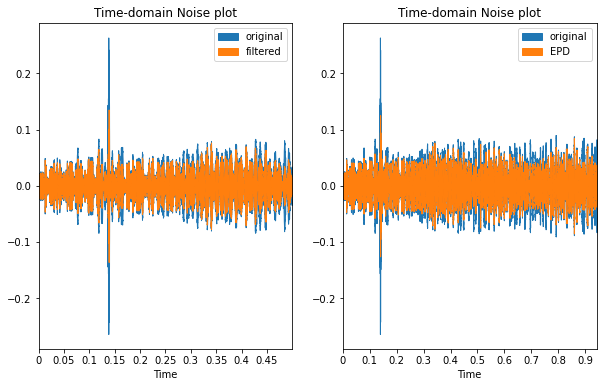

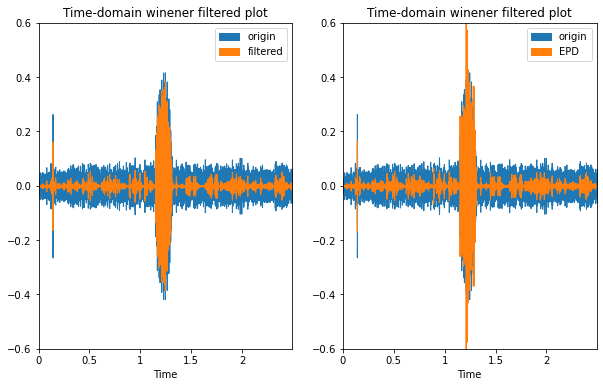

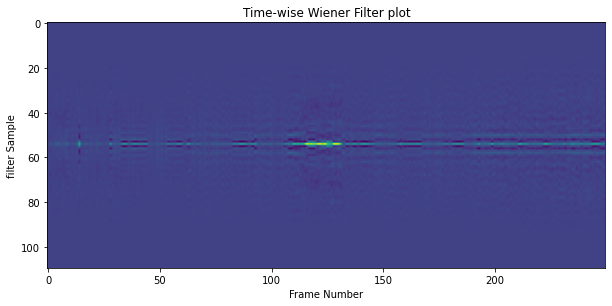

In [167]:
#######################################################

# EPD로 음성신호가 있는 구간을 찾았다고 가정한 경우
    
    # 노이즈가 0 ~ 0.5 [sec]에 있다고 가정한 것(좌측의 figure들)과 유사한 결과를 보인다.
    
    
    # 음성신호가 있는 부분에서 EPD를 쓴 것이 더 큰 진폭을
    # 가진다는 것을 확인할 수 있다. (우측의 figure들)
    
    # 이는, EPD를 쓴 결과로 노이즈의 통계적인 특성과
    # 더 달라졌기 때문이라 생각된다.
    
#######################################################

noise_tilda=x[:Event_start]    

N_tilda=Spectrogram(noise_tilda,Ns,Nf,1)

# 노이즈의 주파수 특성 추정
E_n_tilda=np.mean(np.real(N_tilda*np.conj(N_tilda)),axis=-1) 


mem_x=np.zeros(order-1+Nover)

y_epd=np.zeros(int(N_frame*Nf))

Wiener_Stack_epd=np.zeros((order-1,N_frame))

upslope=np.linspace(0,1,Nover+2)[1:-1]


for f_idx in range(1,N_frame):
    x_i=x[(f_idx-1)*Ns:(f_idx-1)*Ns+Nf]
    h=get_Wiener_filter(x_i,Ns,Nf,order,E_n_tilda)
    Wiener_Stack_epd[:,f_idx]=h
    y_tmp,mem_x = filtering(h,
                            x_i,
                            mem_x,
                            Nover+Nf
                           )
    
    if (f_idx-1)*Nf-Nover>=0:
        y_epd[(f_idx-1)*Nf-Nover:(f_idx-1)*Nf]=y[(f_idx-1)*Nf-Nover:(f_idx-1)*Nf]+upslope*y_tmp[:Nover]
        y_epd[(f_idx-1)*Nf:(f_idx)*Nf]=y_tmp[Nover:]
        y_epd[(f_idx)*Nf-Nover:(f_idx)*Nf]=y[(f_idx)*Nf-Nover:(f_idx)*Nf]*np.flip(upslope)
    else:
        y_epd[(f_idx-1)*Nf:(f_idx)*Nf]=y_tmp[Nover:]
        y_epd[(f_idx)*Nf-Nover:(f_idx)*Nf]=y[(f_idx)*Nf-Nover:(f_idx)*Nf]*np.flip(upslope)        

#############################        

# 시간차원에서의 결과 출력 

#############################

plt.figure(figsize=[10,6])
plt.subplot(1,2,1)
librosa.display.waveplot(x[:N_noise],Fs) # 0~ 0.5 [sec]로 추정한 노이즈 신호
librosa.display.waveplot(x[:N_noise]-y[:N_noise],Fs) # Wiener filtering된 신호
plt.title("Time-domain Noise plot")
plt.legend(["original","filtered"])
plt.subplot(1,2,2)
librosa.display.waveplot(x[:Event_start],Fs) # 추정한 노이즈 신호
librosa.display.waveplot(x[:Event_start]-y_epd[:Event_start]) # EPD로 구해진 noise
plt.title("Time-domain Noise plot")
plt.legend(["original","EPD"])


plt.figure(figsize=[10,6])
plt.subplot(1,2,1)
librosa.display.waveplot(x,Fs) # 입력된 신호
librosa.display.waveplot(y,Fs) # Wiener filtering된 신호
plt.legend(["origin","filtered"])
plt.title("Time-domain winener filtered plot")
plt.ylim([-0.6,0.6])
plt.subplot(1,2,2)
librosa.display.waveplot(x,Fs) # 입력된 신호
librosa.display.waveplot(y_epd,Fs) # EPD와 Wiener filtering된 신호
plt.title("Time-domain winener filtered plot")
plt.legend(["origin","EPD"])
plt.ylim([-0.6,0.6])

plt.figure(figsize=[10,10])
plt.imshow(Wiener_Stack_epd) # Wiener filter의 결과
plt.title("Time-wise Wiener Filter plot")
plt.xlabel("Frame Number")
plt.ylabel("filter Sample")

Audio(y_epd,rate=Fs)
soundfile.write("./kdigits1-3_WienerFiltred_EPD.wav",y_epd,Fs)